## USDA Food Composition

The US Department of Agriculture publishes price estimates for fruits and vegetables [online](https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices/fruit-and-vegetable-prices/). The most recent estimates are based on a 2013 survey of US retail stores. Attached is a csv file with the cleaned fruit data that we will be using. 

In this analysis, I'll combine the price estimates with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list), and then analyze the resulting dataset.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . We set up a cache to work around the limit per hour of calls that the API places on us. 

Note -- an API key is required, I pull mine from a seperate file where the key resides in a text file and is read into the program. 

We begin by importing all relevant libraries and then showing that our function can successfully request the food numbers needed. 

In [1]:
# Import relevant libraries for HW3
%matplotlib inline

import requests 
import requests_cache

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time 

# I store all functions used for hw3 in hw3.py, included in the assingnment repo
from hw3 import *

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = [10, 8]
requests_cache.install_cache("mycache")

In [2]:
key_root = '../keys/data_dot_gov' # link to my keys repo, will need to change
key = read_key(key_root)

# see hw3.py for function documentation
# we pass '' for data base as we want the default, rather than standard reference
quail_eggs = food_search(key, 'quail eggs', '')
quail_eggs


[{'offset': 0,
  'group': 'Branded Food Products Database',
  'name': 'EL COMPI, QUAIL EGGS, UPC: 854955002226',
  'ndbno': '45362205',
  'ds': 'LI',
  'manu': "milly's desserts llc"},
 {'offset': 1,
  'group': 'Branded Food Products Database',
  'name': 'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  'ndbno': '45099560',
  'ds': 'LI',
  'manu': 'Sung Ly International Corporation'},
 {'offset': 2,
  'group': 'Branded Food Products Database',
  'name': 'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  'ndbno': '45169279',
  'ds': 'LI',
  'manu': 'L & M C Farms, Inc.'},
 {'offset': 3,
  'group': 'Branded Food Products Database',
  'name': 'L&W, QUAIL EGGS, UPC: 024072000256',
  'ndbno': '45094890',
  'ds': 'LI',
  'manu': 'L&W International Co.'},
 {'offset': 4,
  'group': 'Branded Food Products Database',
  'name': 'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  'ndbno': '45094707',
  'ds': 'LI',
  'manu': 'Theppadung Porn Coconut Co'},
 {'offset': 5,
  'group': 'Dairy and Egg Pro

Next, we'll clean our data set so that our food numbers coincide with our data points in the csv file. 

In [3]:
fresh = pd.read_csv('fresh.csv')

# clean up our data set additionally and optimize the names for searching through the api
fresh['food'] = fresh['food'].str.replace('_',' ')
fresh.loc[12, 'food'] = 'kiwifruit'
fresh.loc[36, 'food'] = 'green cabbage'
fresh.loc[37, 'food'] = 'red cabbage'
fresh.loc[25, 'food'] = 'cucumbers'
fresh.loc[26, 'food'] = 'peeled cucumbers'
fresh.loc[44,'food'] = 'artichoke (globe or french)'

food_num = match_food(key, fresh['food'])

df = pd.DataFrame.from_dict(food_num, orient='index').T
df = pd.melt(df, var_name='food', value_name='ndb number')
df = df.dropna().set_index('food')

fresh = fresh.set_index('food')
fresh = fresh.merge(df, left_index=True, right_index=True).reset_index()
print(fresh.head())

           food    form  price_per_lb  yield  lb_per_cup  price_per_cup  \
0    watermelon  Fresh1      0.316639   0.52    0.330693       0.201366   
1    cantaloupe  Fresh1      0.520794   0.51    0.374786       0.382718   
2    tangerines  Fresh1      1.480396   0.74    0.407855       0.815929   
3  strawberries  Fresh1      2.508450   0.94    0.319670       0.853060   
4         plums  Fresh1      1.987999   0.94    0.363763       0.769319   

    type ndb number  
0  fruit      09326  
1  fruit      09181  
2  fruit      09221  
3  fruit      09316  
4  fruit      09279  


We obtain the NDB numbers by using our function 'match_food' that iterates through the list of fruits / vegetables and uses our 'food_search' function from problem one to look up the data through the governemnt api. The resulting numbers are stored in a dict: key being the object, value being a list containing the ndb number. We then convert the dict into a data frame and rearrange columns so that we're left with a series of ndb numbers indexed by their associated fruit / vegatable product. 

In [4]:
result1 = ndb_report(key, "09279")
print(result1[0],end='\n\n')
result2 = ndb_report(key, '12345')
print(result2)

{'nutrient_id': '255', 'name': 'Water', 'derivation': 'NONE', 'group': 'Proximates', 'unit': 'g', 'value': '87.23', 'measures': [{'label': 'cup, sliced', 'eqv': 165.0, 'eunit': 'g', 'qty': 1.0, 'value': '143.93'}, {'label': 'fruit (2-1/8" dia)', 'eqv': 66.0, 'eunit': 'g', 'qty': 1.0, 'value': '57.57'}, {'label': 'NLEA serving', 'eqv': 151.0, 'eunit': 'g', 'qty': 1.0, 'value': '131.72'}]}

[]


As seen above, the function takes as input an ndb number and returns a list of the nutrients associated w/ the number. If no match is found, returns an empty list, as in problem 1.

I'll be looking at the following in the coming cells:

- Which food provides the widest variety of nutrients?

- How do the price distributions compare for fruits and vegetables?

In [5]:
# tweak the data set before we compute our statistics / plots

fresh['price_per_lb'] = round(fresh['price_per_cup'] / fresh['lb_per_cup'],2)
top_price = fresh[['food','price_per_lb', 'type']].sort_values(by='price_per_lb', 
                                                           ascending=False)[:10]
# print summary statistics regarding price per pound
print(fresh.groupby('type')['price_per_lb'].describe(), end='\n\n')
print(top_price[:5].set_index(['type']))

            count      mean       std   min    25%    50%     75%   max
type                                                                   
fruit        24.0  2.528333  1.551318  0.61  1.735  2.065  2.9825  7.16
vegetables   25.0  2.620400  1.643382  0.74  1.310  2.270  3.0000  6.30

                                   food  price_per_lb
type                                                 
fruit                       raspberries          7.16
vegetables  artichoke (globe or french)          6.30
vegetables                    asparagus          6.23
vegetables                   corn sweet          6.05
fruit                      blackberries          5.90


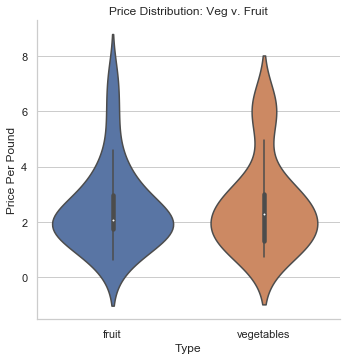

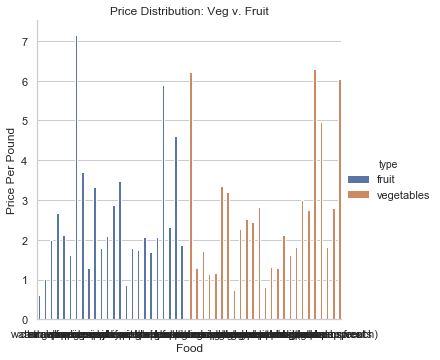

In [6]:
ax1 = sns.catplot('type','price_per_lb', data=fresh, kind="violin")
ax1.set(title = "Price Distribution: Veg v. Fruit", ylabel = "Price Per Pound", xlabel = "Type")

ax2 = sns.catplot(x='food',y='price_per_lb',hue='type', data=fresh,kind='bar')
ax2.set(title = "Price Distribution: Veg v. Fruit", ylabel = "Price Per Pound", xlabel = "Food")

We can see from the summary statistics and graphs printed above that the price distribution of fruits and vegetables is approximately equal, with fruits being more concentrated around the mean / median values while vegetables varies more towards the lowest quartile. The violin plot above also shows us the outliers of both types of produce. Fruit has the largest outlier and then a moderate one, while all the vegetable outliers are clustered together. There doesn't seem to be any similarity between the three vegetables, while the fruits are both berries, which makes sense as berries traditionally cost the most. 

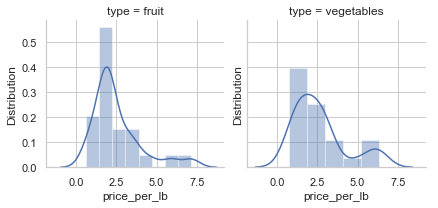

In [7]:
g = sns.FacetGrid(fresh, col='type')
g.map(sns.distplot, 'price_per_lb')
g.set(ylabel='Distribution')

Looking at our kernal density estimation for price per pound, we can see again that our original thoughts are validated, as the distribution of fruit pricing is much more clustered than that of vegetables, with vegetables having positive outliers. 

Now on to the second question, determining which foods carry the most nutrients. In this step, we use our function nutrient_counter to determine the number of nutrients for each of our food items. For each item, we sum up the total nutrient amount and then assign to each nutrient a percentage of the whole. We then round our percents so that any nutrient who makes up less than .1% of the whole is labeled with 0 (one could argue that even .1% is too far and we should round to whole percents, though I'm not fluent in how nutrient amounts impact the body therefore I left it at .1%)

In [8]:
fresh_temp = nutrient_counter(key, fresh)
top_nutrient = fresh_temp.sort_values(by='nutrient count', ascending=False)
top_nutrient = top_nutrient[['type','food','nutrient count']][:10]
dist = fresh_temp[['type','nutrient count', 'food']].sort_values(by='nutrient count', ascending=False)

print(fresh_temp.groupby('type')['nutrient count'].describe())
print(top_nutrient[:5].set_index(['type']))

            count       mean       std   min   25%   50%    75%   max
type                                                                 
fruit        24.0  22.083333  2.811725  15.0  21.0  22.5  23.25  26.0
vegetables   25.0  22.360000  1.468559  20.0  21.0  22.0  23.00  26.0
                    food  nutrient count
type                                    
vegetables      avocados              26
fruit        raspberries              26
fruit       blackberries              26
vegetables    corn sweet              25
fruit       strawberries              25


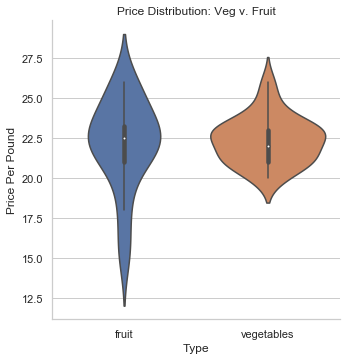

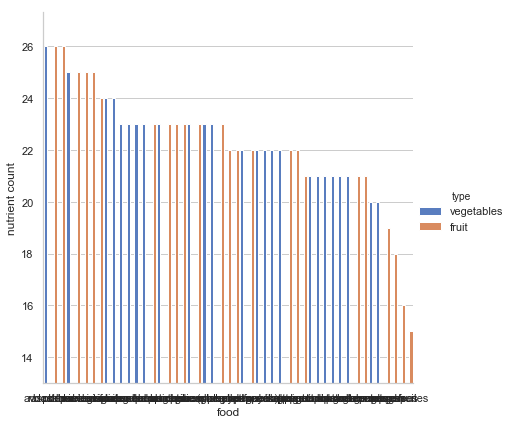

In [9]:
ax1 = sns.catplot('type','nutrient count', data=fresh_temp, kind="violin")
ax1.set(title = "Price Distribution: Veg v. Fruit", ylabel = "Price Per Pound", xlabel = "Type")

g = sns.catplot("food", "nutrient count", "type",
                   data=dist, kind="bar",
                   height=6, palette="muted", legend=True)
plt.ylim(bottom=13)
plt.show()

Looking at our summary statistics for nutrients across food types gives us an idea of what our distribution will look like. While the average (and max) for both fruits and vegetables is approximately equal, the standard deviation of fruit is much larger than that of vegetables, indicating that fruit is not nearly as compact as vegetables. From our summary statistics, this can be seen in the min of fruit being much smaller than the min of vegetables. Looking at our violin plot we can see our thoughts visually. The distribution of fruit is much narrower and longer in the tail (bottom) than vegetables, indicating that the vegetable products nutrient level is much more consistent across food types than fruits. 

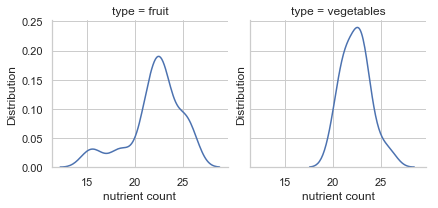

In [10]:
g = sns.FacetGrid(fresh_temp, col='type')
g.map(sns.distplot, 'nutrient count', hist=False)
g.set(ylabel='Distribution')

Finally, looking at our kernel density plots we can see how the distribution for vegetables looks much more like a normal distribution than the fruit dist, which runs out on the leftern tail, which we can see in the violin plot above. 

After exploring the previous two questions, it's worth asking what the relationship between the amount of nutrients and the price of a food actually is. In the above code, we printed the top 5 results when sorting by both price and by nutrient count. Saving the top 10 values and comparing shows us 6 of the top ten are identical. 

In [11]:
top1 = set()  # make a set of the most expensive 
for x in top_price['food']:
    top1.add(x)

top2 = set()
for x in top_nutrient['food']:
    top2.add(x)
top = top1.intersection(top2)

fresh_top = fresh_temp[fresh_temp.food.isin(top)]

cltop = np.corrcoef(fresh_top['price_per_lb'], fresh_top['nutrient count'])[0,1]
cltot = np.corrcoef(fresh_temp['price_per_lb'], fresh_temp['nutrient count'])[0,1]
cltop = cltop.round(2)
cltot = cltot.round(2)

print(fresh_top[['type','price_per_lb','nutrient count']].set_index('type'), end='\n\n')
print('Correllation Coefficient between nutrient count and price per pounds: {}'.format(cltot))

            price_per_lb  nutrient count
type                                    
fruit               7.16              26
fruit               3.71              25
fruit               5.90              26
fruit               4.62              25
vegetables          6.23              24
vegetables          6.05              25

Correllation Coefficient between nutrient count and price per pounds: 0.36


[Text(0, 0.5, 'Nutrient Count'),
 Text(0.5, 0, 'Price Per lb'),
 Text(0.5, 1.0, 'Nutrient Count v. Price Per lb')]

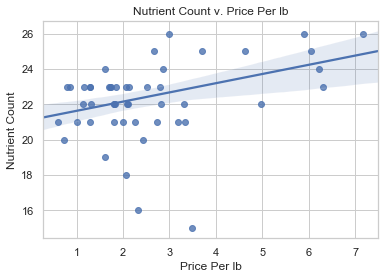

In [12]:
ax = sns.regplot(x = "price_per_lb", y = "nutrient count",robust=True,  data = fresh_temp, fit_reg = True)
ax.set(title = "Nutrient Count v. Price Per lb", xlabel = "Price Per lb", ylabel = "Nutrient Count")


Looking at the relationship between price per pound and nutrient count, we can see a positive relationship between the fresh, raw products we are analyzing. In the above scatter plot and regression line, we used a robust model to take into account the outlier values which we've seen from the initial two questions can skew the distribution. 

Fruit Correlation: 0.4
Vegetable Correlation: 0.34


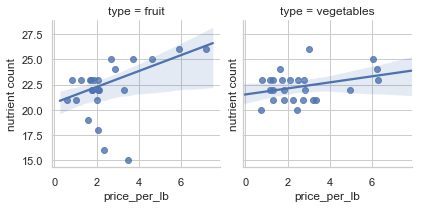

In [13]:
fruit = fresh_temp[fresh_temp['type'] == 'fruit']
veg = fresh_temp[fresh_temp['type'] != 'fruit']

fruit_cor = np.corrcoef(fruit['price_per_lb'], fruit['nutrient count'])[0,1]
veg_cor = np.corrcoef(veg['price_per_lb'], veg['nutrient count'])[0,1]
fruit_cor = fruit_cor.round(2)
veg_cor = veg_cor.round(2)

print('Fruit Correlation: {}\nVegetable Correlation: {}'.format(fruit_cor, veg_cor))

g = sns.FacetGrid(fresh_temp, col='type')
g.map(sns.regplot,'price_per_lb', 'nutrient count', robust=True)
g.set(ylabel='nutrient count')

We run one more regression, this time seperating by the type of food (fruit or vegetable). We can see that, while fruit has a more linear relationship, it also has a much larger error bound than vegetable, which more closely mirrors the regression of the data set as a whole. This is also reflected in the correllation coefficient. Vegetable's, of 0.34 is just under 0.36 for both groups calculated together. 

We can conclude that there is a relationship between price per pound and the amount of nutrients in a food product, though we recognize that there are many unobserved factors that we have not taken into account, some of which may include: seasonality, manufacturer, import/export, gmo / non-gmo. 